In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import time

In [2]:
start = time.time()

In [3]:
def plotBarChartUsingMatplotlib(x_city_arrays, y_delay_arrays, xLabel, yLabel, title):
    y_pos = np.arange(len(x_city_arrays))
    plt.bar(y_pos, y_delay_arrays, align='center', alpha=0.5)
    plt.xticks(y_pos, x_city_arrays)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.show()

In [4]:
airports_df = spark.read.format('csv').option("delimiter", "\t").option("header","true").load("hdfs://hdfs_name_node_hostname:9000/inputdata/spark_test_data/airport-codes-na.txt")

#airports_df.select(F.col('City')).show(2)
#airports_df.printSchema()
airports_df.show(2)
c = airports_df.count()
print("count: " + str(c))

In [5]:
flightPerf_df = spark.read.format('csv').option("header","true").load("hdfs://hdfs_name_node_hostname:9000/inputdata/spark_test_data/departuredelays.csv")

flightPerf_df.show(2)
c = flightPerf_df.count()
print("count: " + str(c))

In [6]:
washington_airports_df = airports_df.filter(airports_df.State == 'WA')
washington_joined_df = flightPerf_df.join(washington_airports_df, (flightPerf_df.origin == washington_airports_df.IATA))
washington_joined_df.show(2)
city_window = Window.partitionBy(F.col("City"), F.col("origin"))
city_df = washington_joined_df.withColumn("Delays", F.sum(F.col("delay")).over(city_window)).select(F.col("City"),F.col("origin"),F.col("Delays")).distinct().orderBy("Delays", ascending=False)
city_df.show(2)

+--------+-----+--------+------+-----------+-------+-----+-------+----+
|    date|delay|distance|origin|destination|   City|State|Country|IATA|
+--------+-----+--------+------+-----------+-------+-----+-------+----+
|01011345|   34|     194|   GEG|        SEA|Spokane|   WA|    USA| GEG|
|01010800|  -10|     194|   GEG|        SEA|Spokane|   WA|    USA| GEG|
+--------+-----+--------+------+-----------+-------+-----+-------+----+
only showing top 2 rows

+-------+------+--------+
|   City|origin|  Delays|
+-------+------+--------+
|Seattle|   SEA|159086.0|
|Spokane|   GEG| 12404.0|
+-------+------+--------+
only showing top 2 rows



In [7]:
usa_airports_df = airports_df.filter(airports_df.Country == 'USA')
usa_joined_df = flightPerf_df.join(usa_airports_df, (flightPerf_df.origin == usa_airports_df.IATA))
usa_joined_df.show(2)
state_window = Window.partitionBy(F.col("State"))
usa_state_df = usa_joined_df.withColumn("Delays", F.sum(F.col("delay")).over(state_window)).select(F.col("State"),F.col("Delays")).distinct().orderBy("Delays", ascending=False)
usa_state_df.show(2)

+--------+-----+--------+------+-----------+---------+-----+-------+----+
|    date|delay|distance|origin|destination|     City|State|Country|IATA|
+--------+-----+--------+------+-----------+---------+-----+-------+----+
|01011245|    6|     602|   ABE|        ATL|Allentown|   PA|    USA| ABE|
|01020600|   -8|     369|   ABE|        DTW|Allentown|   PA|    USA| ABE|
+--------+-----+--------+------+-----------+---------+-----+-------+----+
only showing top 2 rows

+-----+---------+
|State|   Delays|
+-----+---------+
|   TX|1994943.0|
|   CA|1891919.0|
+-----+---------+
only showing top 2 rows



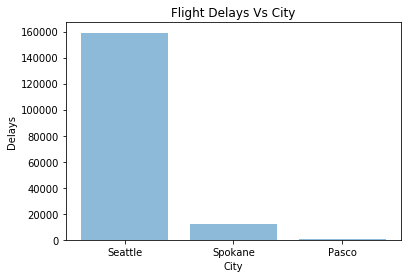

In [8]:
x_city_arrays = city_df.rdd.map(lambda row: row.City).sample(False, 1.0).collect()
y_city_delay_arrays = city_df.rdd.map(lambda row: row.Delays).sample(False, 1.0).collect()
plotBarChartUsingMatplotlib(x_city_arrays, y_city_delay_arrays, "City", "Delays", "Flight Delays Vs City")

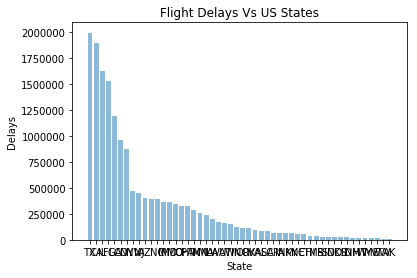

In [9]:
x_state_arrays = usa_state_df.rdd.map(lambda row: row.State).sample(False, 1.0).collect()
y_state_delay_arrays = usa_state_df.rdd.map(lambda row: row.Delays).sample(False, 1.0).collect()
plotBarChartUsingMatplotlib(x_state_arrays, y_state_delay_arrays, "State", "Delays", "Flight Delays Vs US States")

In [10]:
end = time.time()
elapsed = end - start
print("total time: " + str(elapsed))

total time: 48.64138960838318
